# Citi Bike

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import statsmodels.formula.api as smf
from sklearn import linear_model, metrics, cross_validation

In [3]:
bike_data = pd.read_csv('bikeshare.csv')
bike_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Check for Multicollinearity

#### Correlation heat map comparing 'temp', 'atemp', 'casual'

            temp     atemp    casual
temp    1.000000  0.987672  0.459616
atemp   0.987672  1.000000  0.454080
casual  0.459616  0.454080  1.000000
Axes(0.125,0.125;0.62x0.775)


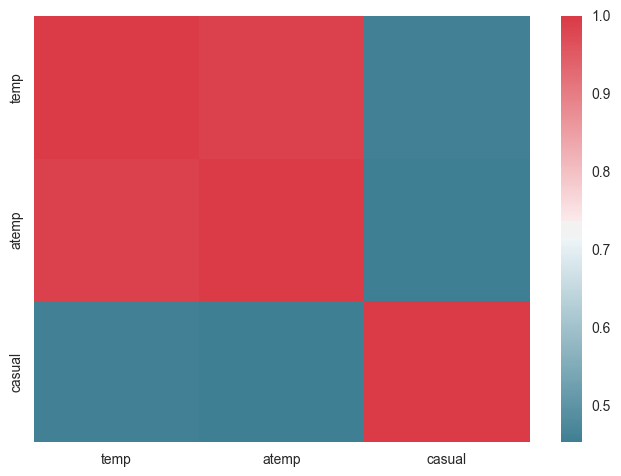

In [4]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

correlations = bike_data[['temp', 'atemp', 'casual']].corr()
print correlations
print sns.heatmap(correlations, cmap=cmap)

- both temperature fields are moderately correlated to guest ridership;
- the two temperature fields are highly correlated to each other.


Including both of these fields in a model could introduce a pain point of multicollinearity, where it's more difficult for a model to determine which feature is effecting the predicted value.

#### We can measure this effect in the coefficients:



In [5]:
from sklearn import feature_selection, linear_model

def get_linear_model_metrics(X, y, algo):
    # get the pvalue of X given y. Ignore f-stat for now.
    pvals = feature_selection.f_regression(X, y)[1]
    # start with an empty linear regression object
    # .fit() runs the linear regression function on X and y
    algo.fit(X,y)
    residuals = (y-algo.predict(X)).values

    # print the necessary values
    print 'P Values:', pvals
    print 'Coefficients:', algo.coef_
    print 'y-intercept:', algo.intercept_
    print 'R-Squared:', algo.score(X,y)
    plt.figure()
    plt.hist(residuals, bins=np.ceil(np.sqrt(len(y))))
    # keep the model
    return algo

temp
P Values: [ 0.]
Coefficients: [ 117.68705779]
y-intercept: -22.812739188
R-Squared: 0.21124654163


/Users/Geraldine/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/Geraldine/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)



atemp
P Values: [ 0.]
Coefficients: [ 130.27875081]
y-intercept: -26.3071675481
R-Squared: 0.206188705733

temp, atemp
P Values: [ 0.  0.]
Coefficients: [ 116.34021588    1.52795677]
y-intercept: -22.8703398286
R-Squared: 0.21124723661



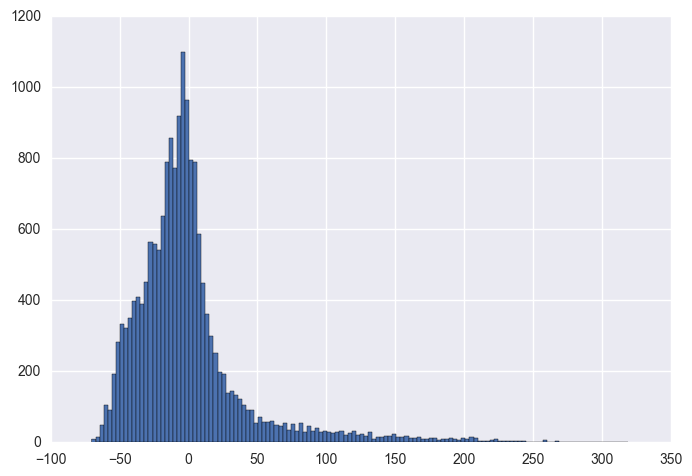

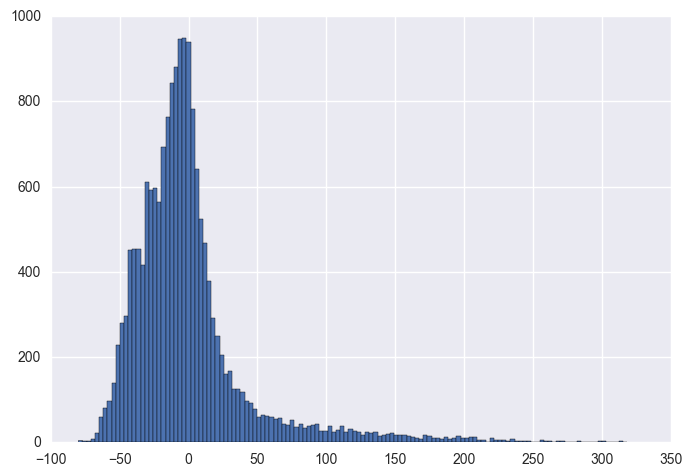

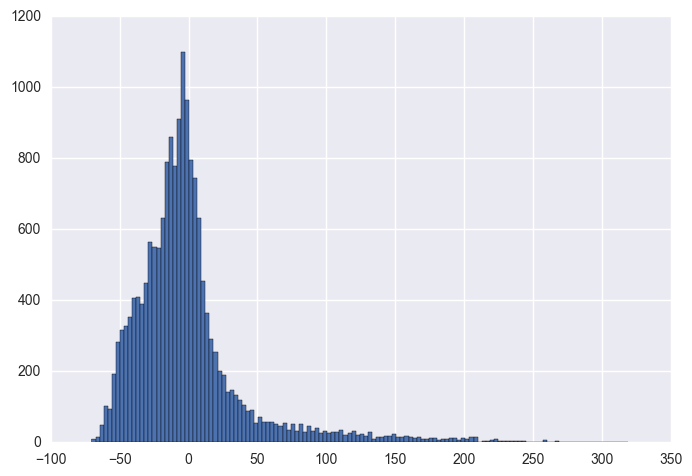

In [6]:
y = bike_data['casual']
x_sets = (
    ['temp'],
    ['atemp'],
    ['temp', 'atemp'],
)

for x in x_sets:
    print ', '.join(x)
    get_linear_model_metrics(bike_data[x], y, linear_model.LinearRegression())
    print

#### Even though the 2-variable model temp + atemp has a higher explanation of variance than two variables on their own, and both variables are considered significant (p values approaching 0), we can see that together, their coefficients are wildly different. 

#### This can introduce error in how we explain models.


#### Try to use a second variable that isn't highly correlated with temperature, like humidity-

P Values: [ 0.  0.]
Coefficients: [ 112.02457031  -80.87301833]
y-intercept: 30.7273338581
R-Squared: 0.310901196913


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

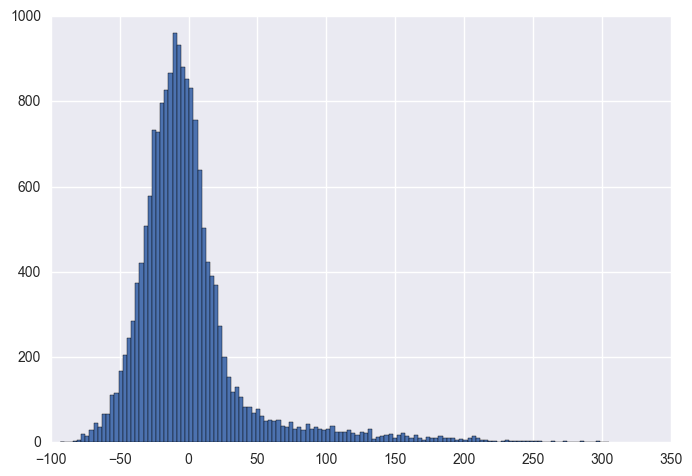

In [7]:
y = bike_data['casual']
x = bike_data[['temp', 'hum']]
get_linear_model_metrics(x, y, linear_model.LinearRegression())


## Multicollinearity with dummy variables

There can be a similar effect from a feature set that is a singular matrix, which is when there is a clear relationship in the matrix (for example, the sum of all rows = 1).

#### What happens to the coefficients when you include all weather situations instead of just including all except one?

P Values: [  3.75616929e-73   3.43170021e-22   1.57718666e-55   2.46181288e-01]
Coefficients: [  5.33996323e+12   5.33996323e+12   5.33996323e+12   5.33996323e+12]
y-intercept: -5.33996323254e+12
R-Squared: 0.0233906300439

P Values: [  3.75616929e-73   3.43170021e-22   1.57718666e-55]
Coefficients: [ 37.87876398  26.92862383  13.38900634]
y-intercept: 2.66666666667
R-Squared: 0.0233906873841


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

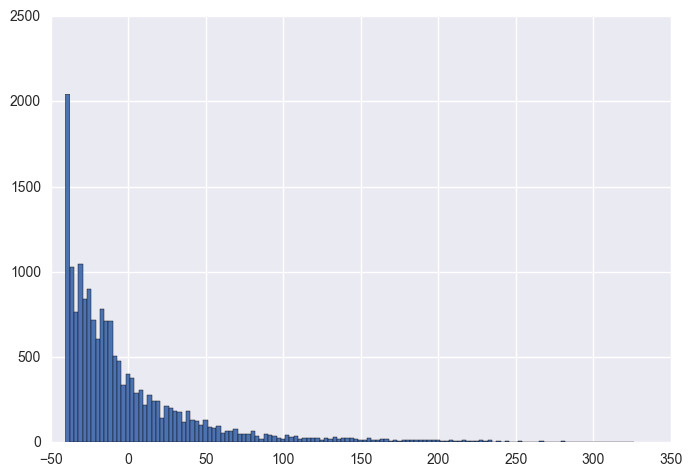

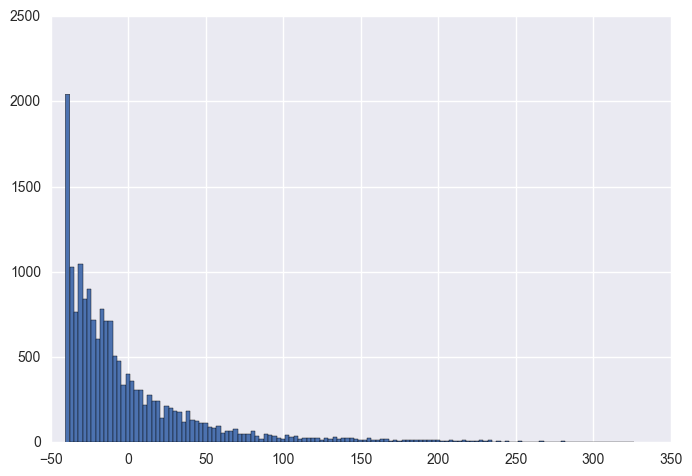

In [8]:
lm = linear_model.LinearRegression()
weather = pd.get_dummies(bike_data.weathersit)

get_linear_model_metrics(weather[[1, 2, 3, 4]], y, lm)
print
# Set one weather as the reference (drop it), weather situation  = 4
get_linear_model_metrics(weather[[1, 2, 3]], y, lm)

#### Similar in Statsmodels

In [9]:
# all dummies in the model
lm_stats = smf.ols(formula='y ~ weather[[1, 2, 3, 4]]', data=bike_data).fit()
lm_stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     103.9
Date:                Sun, 07 May 2017   Prob (F-statistic):           1.38e-87
Time:                        22:00:11   Log-Likelihood:                -92198.
No. Observations:               17379   AIC:                         1.844e+05
Df Residuals:                   17374   BIC:                         1.844e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                -3.565e+13    4.6e+13     -0.774      0.439     -1.26e+14  5.46e+13
weather[[1, 2, 3, 4]][0]  3.565e+13    4.6e+13      0.774      0.439     -5.46e+13  1.26e+14
weather[[1, 2, 3, 4]][1]  3.565e+13    4.6e+13      0.774      0.439     -5.46e+13  1.26e+14
weather[[1, 2, 3, 4]][2]  3.565e+13    4.6e+13      0.774      0.439     -5.46e+13  1.26e+14
weather[[1, 2, 3, 4]][3]  3.565e+13    4.6e+13      0.774      0.439     -5.46e+13  1.26e+14
==============================================================================
Omnibus:                     8985.326   Durbin-Watson:                   0.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58717.202
Skew:                           2.464   Prob(JB):                         0.00
Kurtosis:                      10.537   Cond. No.                     3.46e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.24e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Now drop one

In [10]:
lm_stats = smf.ols(formula='y ~ weather[[1, 2, 3]]', data=bike_data).fit()
lm_stats.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     138.7
Date:                Sun, 07 May 2017   Prob (F-statistic):           8.08e-89
Time:                        22:00:12   Log-Likelihood:                -92197.
No. Observations:               17379   AIC:                         1.844e+05
Df Residuals:                   17375   BIC:                         1.844e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 2.6667     28.134      0.095      0.924       -52.478    57.812
weather[[1, 2, 3]][0]    37.8788     28.138      1.346      0.178       -17.274    93.031
weather[[1, 2, 3]][1]    26.9286     28.143      0.957      0.339       -28.235    82.092
weather[[1, 2, 3]][2]    13.3890     28.164      0.475      0.635       -41.814    68.592
==============================================================================
Omnibus:                     9001.632   Durbin-Watson:                   0.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58962.554
Skew:                           2.468   Prob(JB):                         0.00
Kurtosis:                      10.553   Cond. No.                         189.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpretation: 
This model makes more sense, because we can more easily explain the variables compared to the one we left out. 

For example, this suggests that a clear day (weathersit:1) on average brings in about 38 more riders hourly than a day with heavy snow. 

In fact, since the weather situations "degrade" in quality (1 is the nicest day, 4 is the worst), the coefficients now reflect that well. 

However at this point, there is still a lot of work to do, because weather on its own fails to explain ridership well.




### Checkout our data again

In [11]:
bike_data.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [12]:
bike_data.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


## Building a model to predict guest ridership
- Id categorical variables
- Create dummies (weather situation is done for you in the starter code)
- Find at least two more features that are not correlated with current features, but could be strong indicators for predicting guest riders.

Index([u'instant', u'dteday', u'season', u'yr', u'mnth', u'hr', u'holiday',
       u'weekday', u'workingday', u'weathersit', u'temp', u'atemp', u'hum',
       u'windspeed', u'casual', u'registered', u'cnt', u'weather_1',
       u'weather_2', u'weather_3', u'weather_4'],
      dtype='object')
               temp  weather_1  weather_2  weather_3
temp       1.000000   0.101044  -0.069657  -0.062406
weather_1  0.101044   1.000000  -0.822961  -0.412414
weather_2 -0.069657  -0.822961   1.000000  -0.177417
weather_3 -0.062406  -0.412414  -0.177417   1.000000
Axes(0.125,0.125;0.62x0.775)


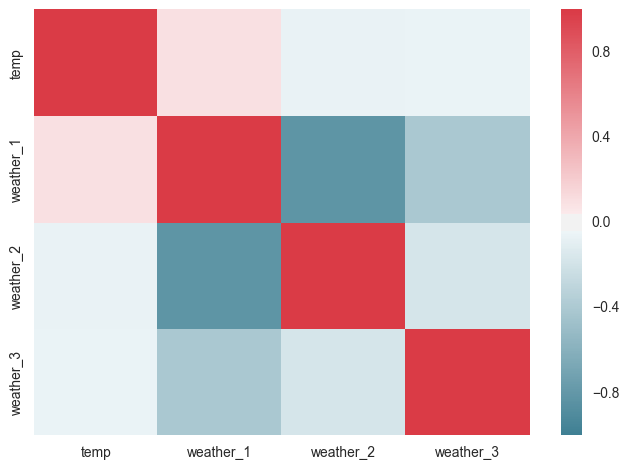

In [13]:
#Dummies example: 
weather = pd.get_dummies(bike_data.weathersit)
#create new names for our new dummy variables
weather.columns = ['weather_' + str(i) for i in weather.columns]
#join those new variables back into the larger dataset
bikemodel_data = bike_data.join(weather)
print bikemodel_data.columns

#Select columns to keep. Don't forget to set a reference category for your dummies (aka drop one)
columns_to_keep = ['temp', 'weather_1', 'weather_2', 'weather_3'] #[which_variables?]

#checking for colinearity
cmap = sns.diverging_palette(220, 10, as_cmap=True)
correlations = bikemodel_data[columns_to_keep].corr()# what are we getting the correlations of?
print correlations
print sns.heatmap(correlations, cmap=cmap)


               temp       hum  windspeed  weather_1  weather_2  weather_3  \
temp       1.000000 -0.069881  -0.023125   0.101044  -0.069657  -0.062406   
hum       -0.069881  1.000000  -0.290105  -0.383425   0.220758   0.309737   
windspeed -0.023125 -0.290105   1.000000   0.005150  -0.049241   0.070018   
weather_1  0.101044 -0.383425   0.005150   1.000000  -0.822961  -0.412414   
weather_2 -0.069657  0.220758  -0.049241  -0.822961   1.000000  -0.177417   
weather_3 -0.062406  0.309737   0.070018  -0.412414  -0.177417   1.000000   
holiday   -0.027340 -0.010588   0.003988   0.009167   0.004910  -0.023664   
hour_1    -0.040738  0.083197  -0.053580   0.008819  -0.006750  -0.005379   
hour_2    -0.045627  0.096198  -0.060241   0.005156  -0.003921  -0.002518   
hour_3    -0.046575  0.108659  -0.065444  -0.001685   0.003843  -0.003117   
hour_4    -0.053459  0.121990  -0.057285  -0.000450   0.000506   0.000096   
hour_5    -0.065571  0.124406  -0.067411  -0.004791   0.011541  -0.010083   

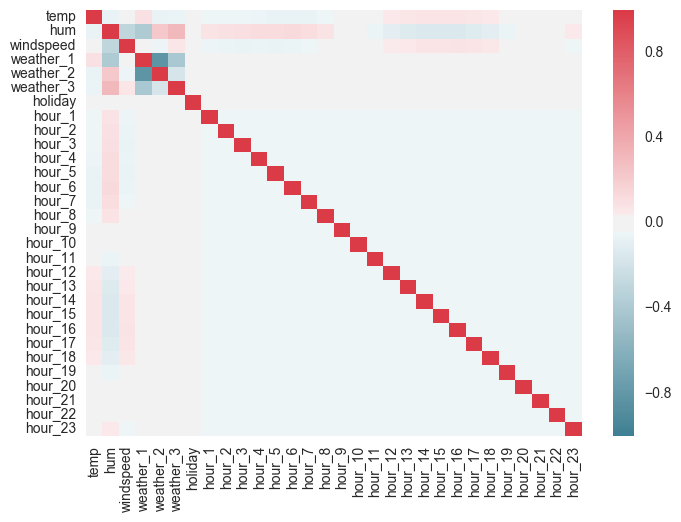

In [14]:
weather = pd.get_dummies(bike_data.weathersit)
weather.columns = ['weather_' + str(i) for i in weather.columns]

hours = pd.get_dummies(bike_data.hr)
hours.columns = ['hour_' + str(i) for i in hours.columns]

season = pd.get_dummies(bike_data.season)
season.columns = ['season_' + str(i) for i in season.columns]


bikemodel_data = bike_data.join(weather) # add in the three weather situations
bikemodel_data = bikemodel_data.join(hours)
bikemodel_data = bikemodel_data.join(season)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

columns_to_keep = ['temp', 'hum', 'windspeed', 'weather_1', 'weather_2', 'weather_3', 'holiday',]
columns_to_keep.extend(['hour_' + str(i) for i in range(1, 24)])

correlations = bikemodel_data[columns_to_keep].corr()
print correlations
print sns.heatmap(correlations, cmap=cmap)

## Cross Validation to Improve Model

In [15]:
weather = pd.get_dummies(bike_data.weathersit, prefix='weather')
modeldata = bike_data[['temp', 'hum']].join(weather[['weather_1', 'weather_2', 'weather_3']])
y = bike_data.casual 

In [16]:
modeldata

,temp,hum,weather_1,weather_2,weather_3
0,0.24,0.81,1.0,0.0,0.0
1,0.22,0.80,1.0,0.0,0.0
2,0.22,0.80,1.0,0.0,0.0
3,0.24,0.75,1.0,0.0,0.0
4,0.24,0.75,1.0,0.0,0.0
5,0.24,0.75,0.0,1.0,0.0
6,0.22,0.80,1.0,0.0,0.0
7,0.20,0.86,1.0,0.0,0.0
8,0.24,0.75,1.0,0.0,0.0
9,0.32,0.76,1.0,0.0,0.0


In [17]:
bike_data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


### Cross validation with 5 folds

In [18]:
kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)

In [19]:
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], 
                                             y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], 
                                                 lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 1687.80623537
R2: 0.311908969759
Model 2
MSE: 1658.49196868
R2: 0.311899660324
Model 3
MSE: 1668.57023211
R2: 0.311893228901
Model 4
MSE: 1653.5980594
R2: 0.31185570106
Model 5
MSE: 1703.02663444
R2: 0.311723272773
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 1674.298626
Mean of R2 for all folds: 0.311856166564


### Linear Regression via SKlearn

In [20]:
lm = linear_model.LinearRegression().fit(modeldata, y)
print "~~~~ Single Model ~~~~"
print 'MSE of single model:', metrics.mean_squared_error(y, lm.predict(modeldata))
print 'R2: ', lm.score(modeldata, y)

~~~~ Single Model ~~~~
MSE of single model: 1672.58110765
R2:  0.311934605989


While the cross validated approach here generated more overall error, the cross-validated averaged model (vs. single model) would predict new data more accurately because it was tested on "outside" data repeatedly and results averaged.